<a href="https://colab.research.google.com/github/sampathv95/Network-Intrusion-Detection/blob/master/network_intrusion_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **NETWORK INTRUSION DETECTION USING DEEP LEARNING**

---



Software applications to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders with malicious intents.  The intrusion detection learning task is to build a predictive model (i.e. a classifier) capable of distinguishing between **'BAD'** connections a.k.a intrusions or attacks, and **'GOOD'** or normal connections.

This notebook demonstrates the process of building a robust intrusion detector with an undelying assumption that intrusions are different types of anomalies which occur rarely and when they do occur, their signature is quite different from that of normal instances.

Whenever an intrusion/anomaly is present, it is mostly visible in one or more features in the collected time-series data. The values of a single feature or combination of features significantly deviate from the rest of the values when everything was normal. Said differently, we can observe a difference in data distribution when an attack/intrusion occurs.

In [0]:
# importing all the necessary packages
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [2]:
# checking if tensorflow version is 2.x
tf.__version__

'2.2.0-rc2'

In [3]:
# checking if gpu is available
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


## Training

### Dataset Description


To model our intrusion detection learning task we use the KDD99 dataset. The KDD99 dataset is the most widespread IDS(Instrusion Detection System) benchmark dataset. Its compilers extracted 41-dimensional features from a raw dataset called DARPA1998 dataset containing both raw TCP(Transmission Control Protocol) packets and labels. Since raw packets are not of much use for ML models. Because of this reason, a new dataset was curated called KDD99 dataset.

The labels in KDD99 are the same as the DARPA1998. There are four types of features in KDD99, i.e., basic features, content features, host-based
statistical features, and time-based statistical features. More about this dataset can be found here: http://kdd.ics.uci.edu/databases/kddcup99/task.html

This dataset can be downloaded from:http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In the above link, there are several versions of the data set. In this work, we used the full version of the datasets



*   train data: http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
*   test data: http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz
*   unlabelled data(production data): http://kdd.ics.uci.edu/databases/kddcup99/kddcup.newtestdata_10_percent_unlabeled.gz

We train our model on **training set**, tune the decision parameters such as classifier threshold and measure the effectiveness metrics on **test set** (can also be called as **validation set**). Finally, we use the **production set** (dataset with no labels) to identify the anomalies. This is helpful bcause when the model goes into production, it mostly would predict on the live data where there are no labels to compare the predictions to.



Let's start by importing the dataset

In [0]:
# setting paths to import train and test data files.
TRAIN_DATA_PATH = 'gdrive/My Drive/capstone2/kdd_train.csv'
COLUMN_NAMES_PATH = 'gdrive/My Drive/capstone2/columns_names.txt'
TEST_DATA_PATH = 'gdrive/My Drive/capstone2/kdd_test.csv'
PROD_DATA_PATH = 'gdrive/My Drive/capstone2/kdd_production.csv'

In [0]:
# reading the training data file
df = pd.read_csv(TRAIN_DATA_PATH, header=None)

In [28]:
# reading the file containing feature names
with open(COLUMN_NAMES_PATH, 'r') as txt_file:
    col_names = txt_file.readlines()
col_names

['duration: continuous\n',
 'protocol_type: symbolic\n',
 'service: symbolic\n',
 'flag: symbolic\n',
 'src_bytes: continuous\n',
 'dst_bytes: continuous\n',
 'land: symbolic\n',
 'wrong_fragment: continuous\n',
 'urgent: continuous\n',
 'hot: continuous\n',
 'num_failed_logins: continuous\n',
 'logged_in: symbolic\n',
 'num_compromised: continuous\n',
 'root_shell: continuous\n',
 'su_attempted: continuous\n',
 'num_root: continuous\n',
 'num_file_creations: continuous\n',
 'num_shells: continuous\n',
 'num_access_files: continuous\n',
 'num_outbound_cmds: continuous\n',
 'is_host_login: symbolic\n',
 'is_guest_login: symbolic\n',
 'count: continuous\n',
 'srv_count: continuous\n',
 'serror_rate: continuous\n',
 'srv_serror_rate: continuous\n',
 'rerror_rate: continuous\n',
 'srv_rerror_rate: continuous\n',
 'same_srv_rate: continuous\n',
 'diff_srv_rate: continuous\n',
 'srv_diff_host_rate: continuous\n',
 'dst_host_count: continuous\n',
 'dst_host_srv_count: continuous\n',
 'dst_hos

In [0]:
col_names_cleaned = [i.split(':')[0] for i in col_names]
# adding an extra column for the indicator
col_names_cleaned.extend(['result'])
# extracting only continous features
continous_col_indices = [col.split(':')[0] for i, col in enumerate(col_names) if col.split(':')[1]==' continuous\n' or col.split(':')[1]==' continuous']

In [30]:
df.columns = col_names_cleaned
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,result
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


### Data Pre-processing

In [31]:
print('different types of services: {}'.format(df['service'].unique()))

different types of services: ['http' 'smtp' 'domain_u' 'auth' 'finger' 'telnet' 'eco_i' 'ftp' 'ntp_u'
 'ecr_i' 'other' 'urp_i' 'private' 'pop_3' 'ftp_data' 'netstat' 'daytime'
 'ssh' 'echo' 'time' 'name' 'whois' 'domain' 'mtp' 'gopher' 'remote_job'
 'rje' 'ctf' 'supdup' 'link' 'systat' 'discard' 'X11' 'shell' 'login'
 'imap4' 'nntp' 'uucp' 'pm_dump' 'IRC' 'Z39_50' 'netbios_dgm' 'ldap'
 'sunrpc' 'courier' 'exec' 'bgp' 'csnet_ns' 'http_443' 'klogin' 'printer'
 'netbios_ssn' 'pop_2' 'nnsp' 'efs' 'hostnames' 'uucp_path' 'sql_net'
 'vmnet' 'iso_tsap' 'netbios_ns' 'kshell' 'urh_i' 'http_2784' 'harvest'
 'aol' 'tftp_u' 'http_8001' 'tim_i' 'red_i']


As there are many types of services in the dataset, and each sevice has different signature and charactersitics, we fixate on data that has only 'http' as the service.

In [0]:
# extracting only the rows which have http service.
df_http = df[(df['service']=='http')]

In [33]:
normal_instances = df_http[df_http['result']=='normal.'].shape[0]
anomalous_instances = df_http[df_http['result']!='normal.'].shape[0]
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

percentage of anomalies = 0.6534247858802092


We can see that that dataset is highly imbalanced i.e. number of anomalous instances in the time-series is much lower than the number of normal instances. Also, this projects a real life scenario where the anomalies seldom occur.

This makes it difficult to approach this problem as supervised learning because of the extreme class imbalance. Hence, we approach this task as as a one class problem where we learn the signature of a particular class which is in abundance (i.e. normal class). The model developed in this approach can identify if an instance is not likely belonging to the trained 'ONE CLASS' and can alert the user depending on metrics such as reconstruction discussed below.

In [0]:
# extracting only the instances belonging to the normal class
df_http_normal = df_http[df_http['result']=='normal.']

In [36]:
df_http_normal.shape

(619046, 42)

In [37]:
# dropping catrgorical columns
df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'result'], axis=1, inplace=True)
# dropping columns with no std deviation
df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
df_http_normal.describe()

,duration,src_bytes,dst_bytes,hot,num_compromised,root_shell,num_root,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,619046.000000,619046.000000,6.190460e+05,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000,619046.000000
mean,0.561887,238.164408,4.099786e+03,0.003489,0.000244,0.000312,0.000013,0.000010,0.005412,8.967949,11.939412,0.001742,0.002147,0.086670,0.087050,0.999875,0.000193,0.111789,127.590137,244.759520,0.997517,0.000701,0.074793,0.031858,0.001152,0.000697,0.087653,0.086727
std,13.927250,126.545153,2.371340e+04,0.081921,0.037207,0.017654,0.003595,0.003113,0.073364,9.252731,11.735141,0.026510,0.025574,0.280405,0.278681,0.007664,0.011216,0.217565,105.902328,39.788676,0.020105,0.006409,0.185882,0.050566,0.013363,0.003392,0.274847,0.268584
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,210.000000,4.580000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,21.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,240.000000,1.425000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,96.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,302.000000,3.727000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,17.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.140000,255.000000,255.000000,1.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.000000,0.000000
max,3289.000000,54540.000000,1.173059e+07,21.000000,21.000000,1.000000,1.000000,1.000000,1.000000,511.000000,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000


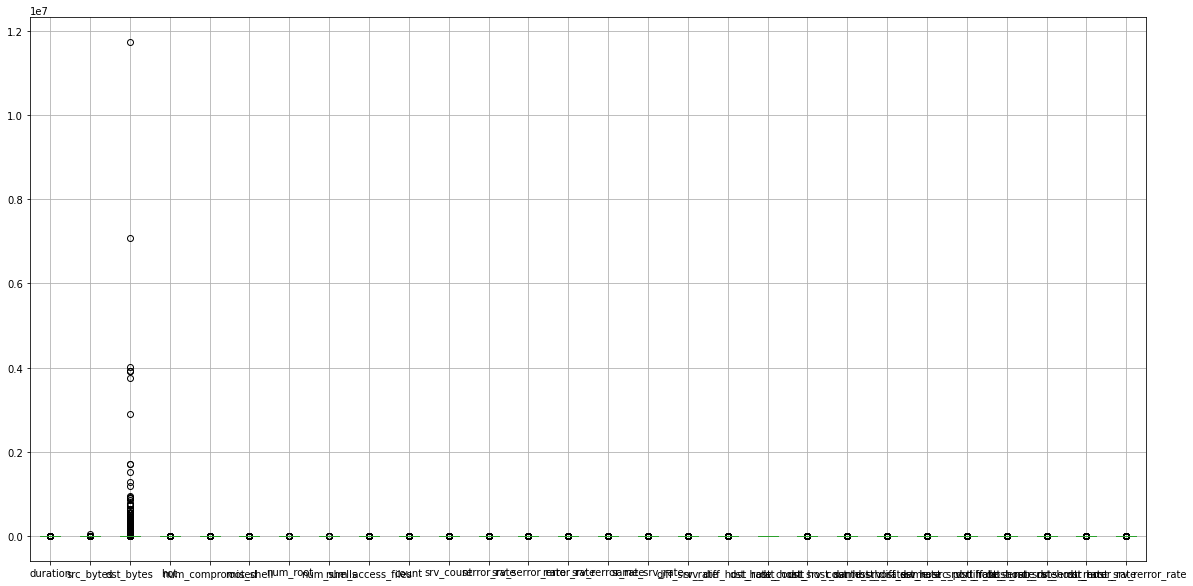

In [39]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

When examining the ranges of values in different features we see that one of them (dst_bytes) has significantly different range than the others. And other features too have different ranges. Using this data as is isn't a good practice as the model will be giving more importance to features having high numerical values. In reality, they might be equally significant as the features with low numerical values.

To overcome this issue, we scale the data using StandardScaler, each value in the feature is scaled by subtracting the mean of the feature and dividing by the standard deviation of the feature. This transforms the feature distribution to a standard normal distribution i.e. normal distribution with 0 mean and unit standard deviation.

In [0]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

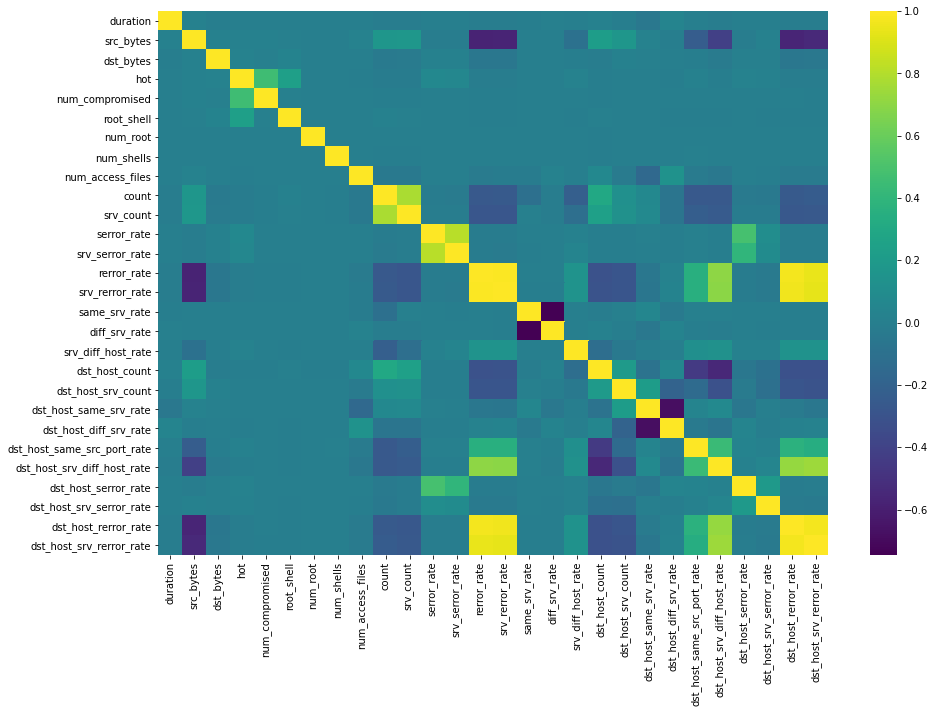

In [41]:
# examining the correlation between different features
plt.figure(figsize=(15, 10))
sns.heatmap(df_http_normal.corr(), cmap='viridis')
plt.show()

Although most feature are mostly not correlated, there are some pairs of error rates that show high correlation. Also the feature shape is of 28 dimensions which is too high to operate with Because of these reasons, we use PCA to reduce the feature space and simultaneously remove any correlations present in between the features.

We aim to cover 80% of the variance present in the original feature space.

In [42]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.8)
pca.fit(df_http_normal)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [44]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
0,-1.798859,3.088944,29.703657,-10.272687,-9.938632,1.727932,5.309854,1.859650,0.355877,0.100662,0.108021,2.466347,-8.499384,-3.726095
1,-1.967497,0.568716,0.771258,-1.566955,1.499832,-0.431848,3.836505,0.189430,0.065545,-0.021060,-0.083078,0.425626,-0.499786,-0.914779
2,-1.269001,0.462764,1.034286,-1.482814,1.074706,-0.349238,3.144712,0.071235,-0.013609,-0.013818,-0.187998,0.231023,-0.123385,-1.041323
3,-1.038257,0.400356,1.093054,-1.340184,0.809126,-0.291742,2.937857,0.099897,-0.038134,-0.010789,-0.217200,0.226344,-0.021436,-1.016548
4,-0.894030,0.357148,1.109916,-1.233189,0.640405,-0.258253,2.864317,0.056544,-0.048781,-0.009322,-0.229586,0.170876,0.016926,-1.008761


The data here is a time-series data even though there is no time stamp present. So we use LSTM(long short term memory) network which is a variant of RNN(recurrent neural networks) aimed to process the sequential nature of data where the order of occurence of data plays an important role.

These networks require 2-D data as the input with dimension (timesteps, features) where the timesteps is a tunable number. So, we use the function below to extract 2-D windows from the data frame with a stride between the windows to ensure the data flow between consecutive windows.

In [0]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [46]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 61904/61904 [00:11<00:00, 5522.91it/s]


In [0]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

### LSTM Autoencoder

Autoencoders majorly come under self supervised learning. There are two parts in an autoencoder: encoder and decoder. The encoder takes in the input (2-D here) and compresses it into a latent vector of lower (sometimes higher) dimension. The decoder takes in this latent vector and attempts to reconstruct the input data as closely as possible.

The process of reconstruction ensures that the latent vectors have some meaningful information in them and are not any random vectors.

One of the major applications of autoencoders is non linear dimensionality reduction where the latent representation is used further downstream in the process to train models. The autoencoders also perform well on capturing the distribution of data through reconstruction.

Let's go ahead build one using the tf.keras library of the famous tensorflow deep learning framework.

In [47]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 14), dropout=0.2), LSTM(50, activation='selu', return_sequences=True), 
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True), 
                      TimeDistributed(Dense(14, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 20)                62280     
_________________________________________________________________
decoder (Sequential)         (None, 10, 14)            57254     
Total params: 119,534
Trainable params: 119,534
Non-trainable params: 0
_________________________________________________________________


In [48]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 80)            30400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            26200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                5680      
Total params: 62,280
Trainable params: 62,280
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 10, 20)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 50)            14200     
______________________________________

(None, None)

Now, we train the model using the data generated above. A small portion of data called the validation set is set aside to measure the performance of the model at the end of each epoch. The model and it's set of parameters which tend to perform best on the validation data is saved if the there is a improvement in performance. Later this model is restored for inference purposes.

In [0]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=100, callbacks=[check_point])

Epoch 1/100
774/774 [==============================] - ETA: 0s - loss: 0.4318
Epoch 00001: val_loss improved from inf to 0.36632, saving model to autoencoder.h5
774/774 [==============================] - 80s 103ms/step - loss: 0.4318 - val_loss: 0.3663
Epoch 2/100
774/774 [==============================] - ETA: 0s - loss: 0.3877
Epoch 00002: val_loss improved from 0.36632 to 0.33195, saving model to autoencoder.h5
774/774 [==============================] - 80s 103ms/step - loss: 0.3877 - val_loss: 0.3320
Epoch 3/100
774/774 [==============================] - ETA: 0s - loss: 0.3902
Epoch 00003: val_loss improved from 0.33195 to 0.32236, saving model to autoencoder.h5
774/774 [==============================] - 79s 102ms/step - loss: 0.3902 - val_loss: 0.3224
Epoch 4/100
774/774 [==============================] - ETA: 0s - loss: 0.3503
Epoch 00004: val_loss improved from 0.32236 to 0.30271, saving model to autoencoder.h5
774/774 [==============================] - 79s 102ms/step - loss: 0.

In [49]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5') 

## Testing

The model is trained and the model with best parameters is restored. Now we have to load the test set and perform the same preprocessing steps done to the training data.

We must use the same scaler and PCA objects that were fitted to the training data. This is done to maintain the consistency of transformation betwwen the train and test data.

### Test data pre-processing

In [82]:
# loading the test dataframe
test_df = pd.read_csv(TEST_DATA_PATH, header=None, names=col_names_cleaned)
test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,result
0,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [0]:
# slicing only the rows belonging to http service
test_df_http = test_df[test_df['service']=='http']

While extracting windows out of test data, we a particular eindow to be anomalous if there are one or more anomalous samples in the window.

In [0]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='normal.' else 1 for i in test_df_http['result']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [85]:
# dropping catrgorical columns
test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'result'], axis=1, inplace=True)
# dropping columns with no std deviation
test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
test_df_http = pd.DataFrame(scaler.transform(test_df_http), columns=test_df_http.columns)

In [87]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
0,0.447803,-0.037561,-0.071583,-0.519532,0.682330,-0.205302,-0.274752,-0.070554,0.002780,-0.001089,-0.081894,0.064140,0.286993,-0.711321
1,-0.373923,11.626108,-0.761246,0.648020,-0.758655,-1.514405,3.321931,-0.439838,-0.056738,-0.015726,-0.136585,-0.650677,0.658160,-0.324815
2,0.751391,-0.036574,0.095399,-0.642058,0.691667,-0.157171,-0.723175,0.283788,-0.012771,-0.007231,-0.078363,0.380921,0.426132,-0.605115
3,1.099520,-0.256337,-0.075035,0.127901,-0.169646,0.016458,-0.299179,0.018593,0.001819,-0.005264,-0.044151,0.120868,0.233207,-0.385393
4,1.415546,-0.428898,-0.239097,0.787054,-0.880944,0.180008,0.052757,-0.087440,0.008501,-0.001091,0.021312,-0.060214,-0.194313,0.196281


In [88]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 4123/4123 [00:00<00:00, 5681.16it/s]


In [0]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

The reconstruction error is used a metric to predict the likelyhood of a sample/instance being anomalous.

The reason beehind this is that we used only the normal data for reconstruction using the autoencoder. During inference, if the model encounters an anomalous sample, the encoder compresses it to a latent representation that is similar to that of normal data (because it has been trained to only compress normal data). This latent representation misses the information related to anomalous charactersitics and the decoder reconstructs this as a normal sample resulting in large reconstruction error.

After calculating reconstruction errors for all the samples in the test data, we can scale them to [0, 1] range called the anomaly score. A threshold can be set on this anomaly score above which the sample is identified as anomalous.

In [0]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [0]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [0]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

Looking at the plot below, we can see that the model is able to succesfully identify most of the anomalies i.e the samples where both the blue and red lines are high.

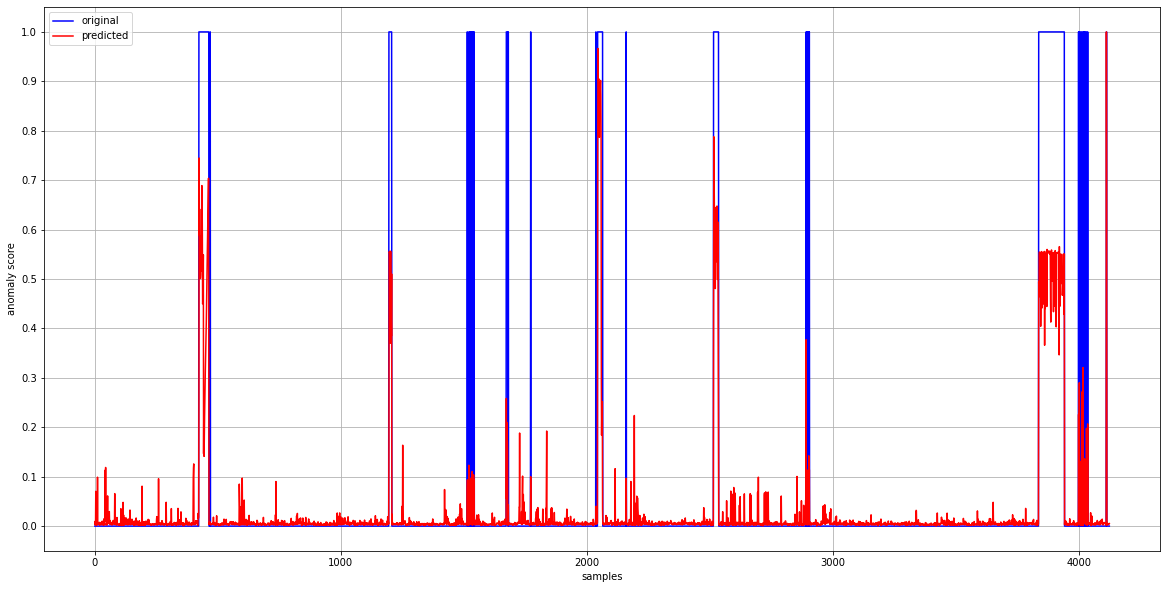

In [97]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

### Measuring the effectiveness of classifier

In a typical classification problem setting, ROC-AUC(receiver operating characteristic area under the curve) is used as the de-facto metric to measure the effectiveness of a classifier i.e. how well the classifier is able to distinguish between the two classes.
 ROC is the plot of TPR(true positive rate) vs FPR(false positive rate) as a result of different thresholds. Higher area (close to 1) under this curve indicates that the classifier is very good at distinguishing the classes and lower area (close to 0.5), the classifier cannot determine the difference between the classes, which is as good as a random guess.

In [0]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [99]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.9981452339326364


The area under the curve is almost equal to 1 signifying the effectiveness of the classifier.

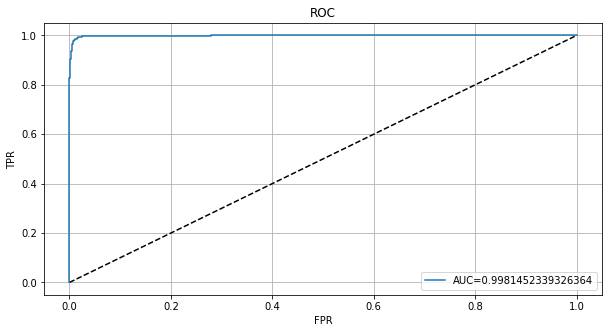

In [100]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()

### Identifying anomalies in test set

Next comes the task of determining an optimal value of threshold above the the sample is labeled anomalous. As we can see from the above plot, the optimal threshold value is not 0.5 as this not a classification probel with class balance. From visual perspective , the threshold is nore likely to be in the range of [0.05, 0.15]

Setting the thresold value too low can help in identifying all the anomalies but also the samples that are not actually anomalies are labeled as anomalies (false positives). This might not be a pleasant experience for the person monitoring through this application. A higher threshold value might prevent these false negatives but increase the risk of predicting the actual anomalies to be normal (false negatives). This might lead to ignorance of potential threats that could jeopadize the security of an organization.

So, we use a metric called F-1 score which is the equally weighted harmonic mean of precision(measure of imapact of false positives) and recall(measure of imapact of false negatives. Finally we pick the threshold value with the highest F-1 score.

In [0]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

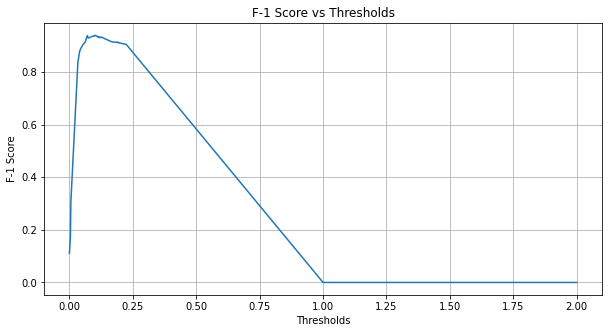

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [103]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 0.09994484484195709


In [0]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [105]:
confusion_matrix(test_labels, anomaly_indicator)

array([[3870,   11],
       [  18,  224]])

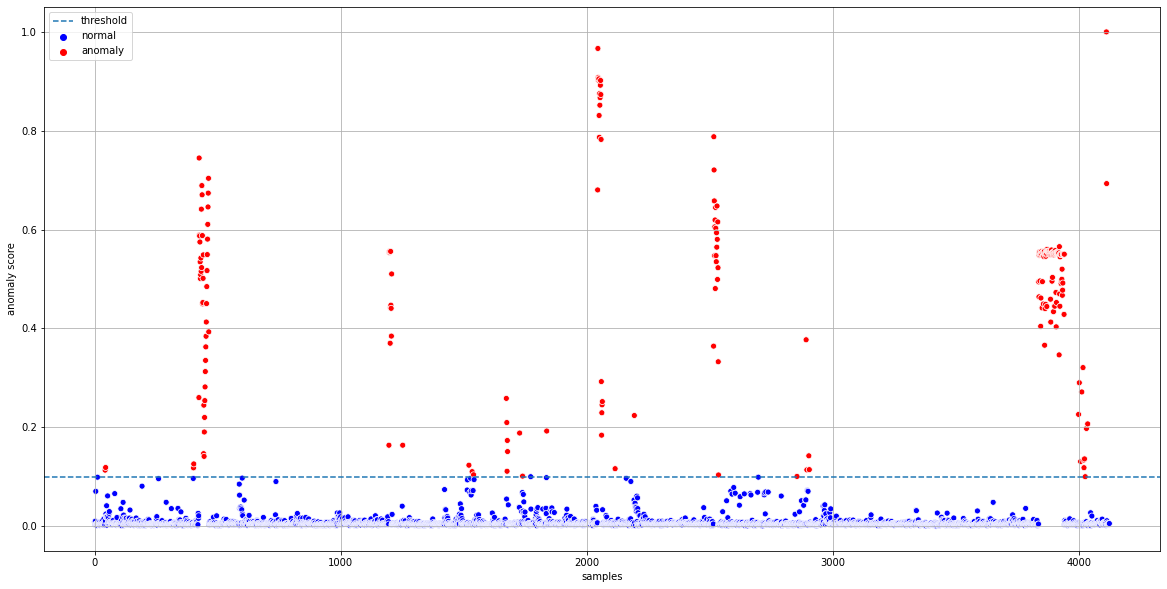

In [108]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

### Performance metrics

In [0]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [110]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.9531914893617022
 recall = 0.9256198347107438
 f1_score = 0.9392033542976939
 accuracy_score = 0.9929662866844531


## Inference on Production Dataset

In [0]:
prod_df = pd.read_csv(PROD_DATA_PATH, header=None, names=col_names_cleaned)

In [114]:
# slicing only the rows belonging to http service
prod_df_http = prod_df[prod_df['service']=='http']
prod_df_http.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,result
8,0,tcp,http,SF,284,765,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76,251,1.0,0.0,0.01,0.05,0.0,0.0,0.0,0.0,NaN
9,0,tcp,http,SF,304,3634,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14,14,0.0,0.0,0.0,0.0,1.0,0.0,0.0,86,251,1.0,0.0,0.01,0.05,0.0,0.0,0.0,0.0,NaN
10,0,tcp,http,SF,286,659,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,24,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,96,251,1.0,0.0,0.01,0.05,0.0,0.0,0.0,0.0,NaN
11,0,tcp,http,SF,298,5320,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,34,34,0.0,0.0,0.0,0.0,1.0,0.0,0.0,106,251,1.0,0.0,0.01,0.05,0.0,0.0,0.0,0.0,NaN
13,0,tcp,http,SF,290,365,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,117,251,1.0,0.0,0.01,0.04,0.0,0.0,0.0,0.0,NaN


In [115]:
prod_df_http.shape

(41192, 42)

In [116]:
# dropping catrgorical columns
prod_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'result'], axis=1, inplace=True)
# dropping columns with no std deviation
prod_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
prod_df_http = pd.DataFrame(scaler.transform(prod_df_http), columns=prod_df_http.columns)

In [118]:
prod_df_http_pca = pd.DataFrame(pca.transform(prod_df_http), columns=pca_cols)
prod_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
0,0.297360,-0.032057,-0.121376,-0.526900,0.739751,-0.209450,-0.043693,-0.067645,0.003968,-0.000832,-0.075895,0.074969,0.287922,-0.681393
1,0.710282,-0.230791,-0.290100,0.195176,-0.048202,-0.015575,0.403405,0.035467,0.020562,0.001170,-0.024612,0.163951,0.068895,-0.299118
2,1.039008,-0.440383,-0.462668,0.956009,-0.890064,0.170545,0.816749,-0.016169,0.035937,0.003345,0.016734,0.103992,-0.132922,0.008159
3,1.436586,-0.636894,-0.632507,1.679161,-1.677273,0.367741,1.256743,0.141375,0.052662,0.005434,0.069331,0.243556,-0.353076,0.411528
4,0.632666,-0.155772,-0.143185,-0.132561,0.239163,-0.091299,-0.005238,-0.070818,0.006328,-0.001903,-0.056586,0.057895,0.224589,-0.517693


In [119]:
prod_windows = get_windows(prod_df_http_pca, window_size=10, stride=10)

100%|██████████| 4119/4119 [00:00<00:00, 5458.35it/s]


In [0]:
prod_windows_pred = autoencoder_loaded.predict(prod_windows)

In [0]:
prod_recon_errors = get_recon_erros(prod_windows, prod_windows_pred)
prod_recon_errors = np.array(prod_recon_errors).reshape(-1, 1)

In [0]:
mm_scaler_prod = MinMaxScaler()
prod_anomaly_scores = mm_scaler_prod.fit_transform(prod_recon_errors).flatten()

In [0]:
prod_anomaly_indicator = (prod_anomaly_scores>best_threshold).astype(np.int32)

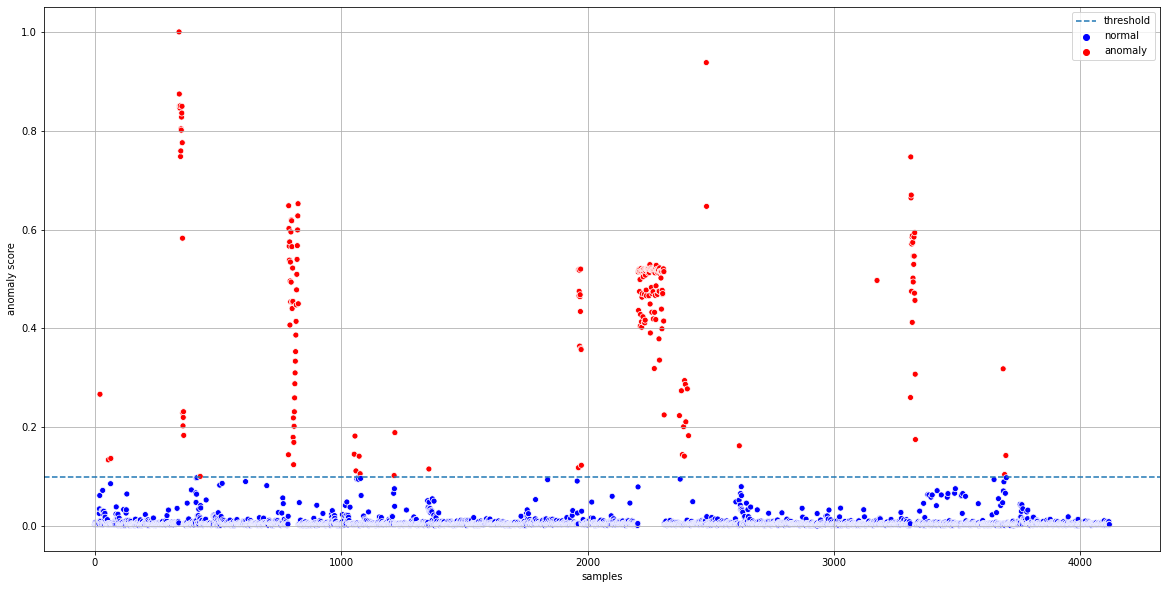

In [136]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(prod_anomaly_scores)), y= prod_anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in prod_anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()